In [1]:
import matplotlib
matplotlib.use('TKAgg')

import scipy.io as spio
import numpy as np
import matplotlib.pyplot as plt

def loadmat(filename):
    '''
    this function should be called instead of direct spio.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects
    '''
    data = spio.loadmat(filename, struct_as_record=False, squeeze_me=True)
    return _check_keys(data)

def _check_keys(dict):
    '''
    checks if entries in dictionary are mat-objects. If yes
    todict is called to change them to nested dictionaries
    '''
    for key in dict:
        if isinstance(dict[key], spio.matlab.mio5_params.mat_struct):
            dict[key] = _todict(dict[key])
    return dict        

def _todict(matobj):
    '''
    A recursive function which constructs from matobjects nested dictionaries
    '''
    dict = {}
    for strg in matobj._fieldnames:
        elem = matobj.__dict__[strg]
        if isinstance(elem, spio.matlab.mio5_params.mat_struct):
            dict[strg] = _todict(elem)
        else:
            dict[strg] = elem
    return dict

Factor Analysis & Expectation Maximization (EM algorithm)
---

Solve the factor analysis model: $$y = A x + \nu$$

Where $y$ is the data, $A$ is the mixing matrix (factor loading matrix), $x$ is the unknown, and $\nu$ is the noise. 

Let's load the data first, this data is an auditory evoked field (AEF) recording provided by Dr. Chang Cai, Dr. Srikantan Nagarajan, and Dr. John Houde's group. 
I am not sure what the actual stimulus was, but the data includes the following:

```
struct with fields:

                 data: [720x274 single]
          sensorCoord: [274x3x2 double]
         sensorOrient: [274x3 double]
                srate: 1200
              latency: [720x1 double]
                  lsc: [1.1200 -1.5000 53.0800]
        sensor_labels: {1x274 cell}
                Gcoef: [274x29 double]
           grad_order: 1
       refSensorCoord: [29x3x2 double]
      refSensorOrient: [29x3 double]
    ref_sensor_labels: {1x29 cell}
         goodchannels: [1x274 double]
```

In [3]:
MEG_dict = loadmat('nuts_meg_data.mat')
print('The data field contains {0} rows and {1} columns'.format(MEG_dict['nuts']['meg']['data'].shape[0], MEG_dict['nuts']['meg']['data'].shape[1]))
print('The sampling rate is {0} times per second'.format(MEG_dict['nuts']['meg']['srate']))

The data field contains 720 rows and 274 columns
The sampling rate is 1200 times per second


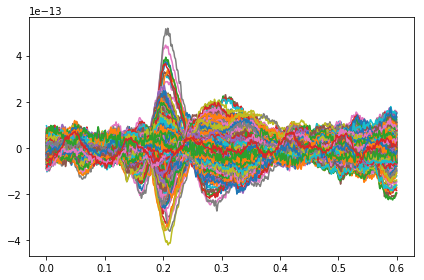

In [4]:
%matplotlib inline

# Visualize:
t = np.linspace(0,720,720)/1200
plt.plot(t,MEG_dict['nuts']['meg']['data']);
plt.tight_layout()

From previous class notes, the BFA framework includes the following: 

$$ y = ax + \nu $$$ 
$$$ P(x) = \prod_{t=1}^{T} \mathcal{N}\left(x_{t} | 0, I\right) $$$
$$$ P(\nu) = \prod_{t=1}^{T} \mathcal{N}\left(\nu_{t} | 0, \Lambda\right) $$$
$$$ P(A) = \prod_{T_j} P(A_{ij} | 0, \alpha_{ij}) $$

where $\Lambda$ is the noise precision.

If all variations in the data come from our latent variables, not A, we can simplify $P(A)$ to $P(A) = \delta(A-\hat{A})$. Then the unkowns we have are $A$, $x$, and $\Lambda$, and $\Lambda$ is a diagonal noise matrix, making our problem a <em>"heteroscedastic noise model"</em>. We aim to compute $p(x|y)$.

For expectation-maximization, we want to 
 - 1) Compute $P(x|y)$
 - 2) Compute $\mathbb{E} P(x|y) [log P(y,x)]$
 - 3) Maximize $\mathbb{E} P(x|y) [log P(y,x)]$
 
For step 1 - We know $log P(x|y) = log P(y|x) + log P(x) + constant$, and if we expand this equation out we can find $\bar{x}$ and $\Gamma$, which comes from the first and second order derivatives of $L$ respectively.

For step 2 - We make use of Baye's rule, the joint distribution $P(y,x)$ is $P(y|x)P(x)$, so $\mathbb{E}_{P(x|y)}[log P(y,x)] = \mathbb{E}_{P(x|y)}{L}$

For step 3 - We need to find $A$ and $\Lambda$ by taking the derivative of the log-likelihood $\mathbb{F}$ with respect to $A$ and $\Lambda$.

Solutions to unknowns:

$$ \bar{x} = \Gamma^{-1} A^{T} \Lambda y$$
$$ \Gamma = A^T \Lambda A + I $$
$$ A = R_{xx}^{-1} R_{yy}$$
$$ \Lambda^{-1} = diag((y - \bar{A}\bar{x})(y -\bar{A}\bar{x}^T))$$

These solutions make up the update rules that will maximize the log likelihood in the expectation maximization algorithm:

#### Extract the data and compute it's autocorrelation:

In [5]:
# we want rows = Nsensors (274) and columns = Ntimes(720) 
y = np.transpose(MEG_dict['nuts']['meg']['data'])
num_y = y.shape[0] #data number of sensors
num_t = y.shape[1] #data time samples

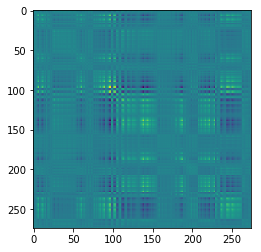

In [6]:
# auto-correlation:
autocorr_yy = np.matmul(y,np.transpose(y))

# visualize:
plt.imshow(autocorr_yy);

#### Initialize by singular value decomposition and compute the mixing matrix and diagonal noise precision matrix:

In [7]:
num_it = 20 # number of EM-iterations
num_fa = 5  # number of factors used 

U, SV, V = np.linalg.svd(autocorr_yy/num_t)
D = np.diag(SV)

mixing_matrix = U * np.diag(np.sqrt(D))
mixing_matrix = mixing_matrix[:,0:num_fa]
noise_precision_matrix = np.diag(num_t/np.diag(autocorr_yy))

# EM iteration:
likelihood = np.zeros([num_it, 1])
lambda_psi = np.matmul(np.matmul(np.transpose(mixing_matrix),noise_precision_matrix), mixing_matrix)

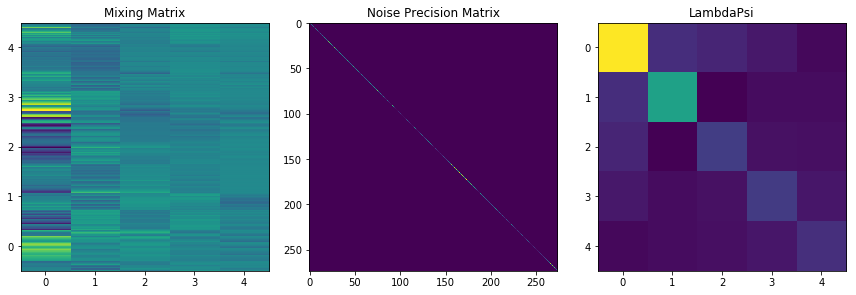

In [8]:
fig1, (ax_1, ax_2, ax_3) = plt.subplots(1,3, figsize = (12,9))
ax_1.imshow(mixing_matrix, extent = (-0.5, 4.5, -0.5, 4.5))
ax_1.set_title('Mixing Matrix')
ax_2.imshow(noise_precision_matrix)
ax_2.set_title('Noise Precision Matrix')
ax_3.imshow(lambda_psi)
ax_3.set_title('LambdaPsi')
plt.tight_layout()

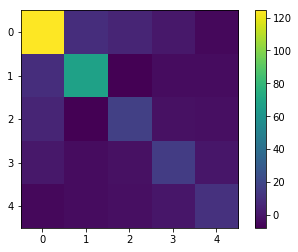

In [9]:
gamma = lambda_psi + np.eye(num_fa) #precision
im = plt.imshow(gamma); plt.colorbar(im);

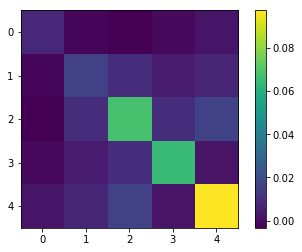

In [10]:
igamma = np.linalg.inv(gamma) # variance
im2 = plt.imshow(igamma); plt.colorbar(im2);

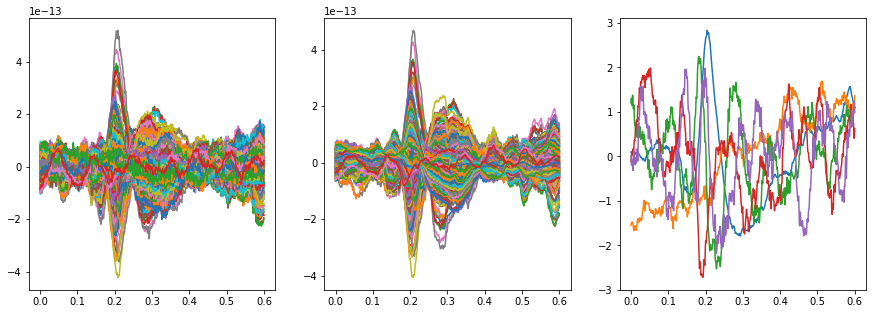

In [11]:
# visualize y, ybar, xbar side by side
xbar = np.matmul(np.matmul(np.matmul(igamma, np.transpose(mixing_matrix)),noise_precision_matrix), y)
ybar = np.matmul(mixing_matrix,xbar)
fig, ax = plt.subplots(1,3, figsize = (15, 5))
ax[0].plot(t,y.transpose());
ax[1].plot(t,ybar.transpose());
ax[2].plot(t,xbar.transpose());

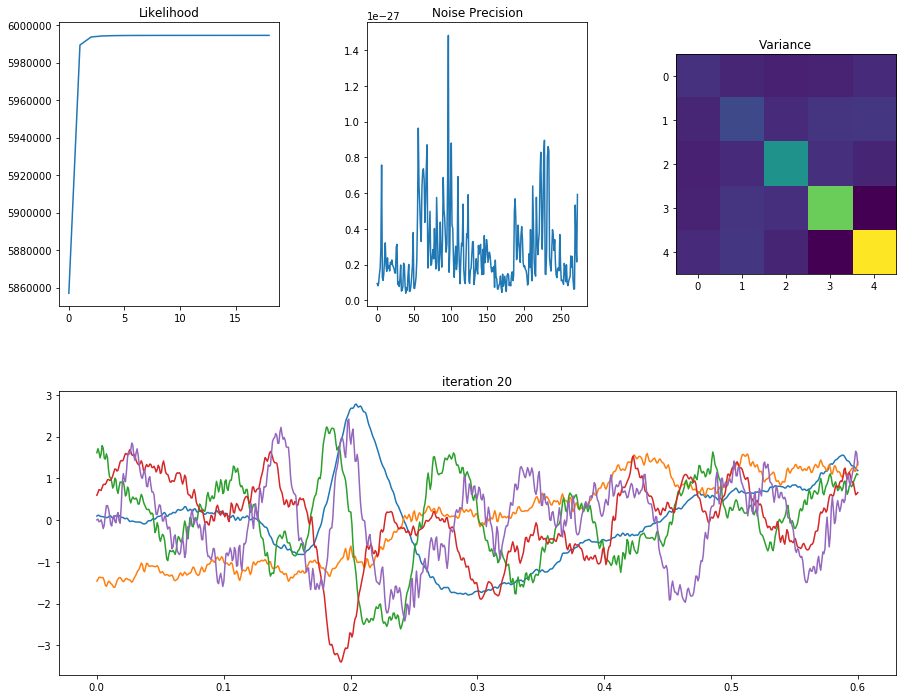

In [12]:
%matplotlib qt

fig2 = plt.figure(figsize = (15,12))
grid = plt.GridSpec(2, 3, wspace=0.4, hspace=0.3)
lh_ax = fig2.add_subplot(grid[0, 0])
np_ax = fig2.add_subplot(grid[0, 1])
ig_ax = fig2.add_subplot(grid[0, 2])
xb_ax = fig2.add_subplot(grid[1,0:])

for i in np.arange(0, num_it):
    gamma = lambda_psi + np.eye(num_fa)
    igamma = np.linalg.inv(gamma)
    xbar = np.matmul(np.matmul(np.matmul(igamma, np.transpose(mixing_matrix)),noise_precision_matrix), y)

    # update rules:
    ldnpm = np.sum(np.log(np.diag(noise_precision_matrix/(2*np.pi))))
    ldgam = np.sum(np.log(np.linalg.svd(gamma)[1]))
    likelihood[i] = 0.5*num_t*(ldnpm - ldgam) - 0.5*np.sum(np.sum(y*np.matmul(noise_precision_matrix,y))) + 0.5*np.sum(np.sum(xbar*np.matmul(gamma,xbar)))
    
    # update:
    ryx = np.matmul(y,xbar.transpose())
    rxx = np.matmul(xbar,xbar.transpose()) + num_t*igamma
    psi = np.linalg.inv(rxx)
    mixing_matrix = np.matmul(ryx,psi)
    noise_precision_matrix = np.diag(num_t/np.diag(autocorr_yy - np.matmul(mixing_matrix, ryx.transpose())))
    lambda_psi = np.matmul(mixing_matrix.transpose(), np.matmul(noise_precision_matrix, mixing_matrix))
        
    # visualize updates:
    lh_ax.clear()
    np_ax.clear()
    xb_ax.clear()
    ig_ax.clear()
    lh_ax.plot(np.arange(0,i),likelihood[:i])
    lh_ax.set_title('Likelihood')
    np_ax.plot(1/np.diag(noise_precision_matrix))
    np_ax.set_title('Noise Precision')
    ig_ax.imshow(igamma)
    ig_ax.set_title('Variance')
    xb_ax.plot(t, xbar.transpose())
    xb_ax.set_title('iteration {}'.format(i+1))
    fig2.canvas.draw()
    fig2.canvas.flush_events()
    plt.show()
    plt.pause(0.5)

In [13]:
## Function for vb-fa:
def bfa(y, num_fa, num_it, mixing_matrix = None, noise_precision = None):
    """
    Bayesian Factor analysis with expectation maximization algorithm
    
    Args:
        - y (array): Nsensor x Ntime data 
        - num_fa (int): number of factors in factor analysis
        - num_it (int): number of iterations for EM updates
        - mixing_matrix (array): The factor loading matrix A in the factor analysis model. If stays as default value of None, the function initializes with SVD of autocorrelation of y
        - noise_precision (array): the noise precision matrix, also defaults to None and can be initialized.
    
    Outputs: (everything gets plotted)
        - mixing_matrix
        - noise_precision
        - xbar - x after update rules are applied.
        - igamma - the variance matrix
    """
    num_y = y.shape[0] #data number of sensors
    num_t = y.shape[1] #data time samples
    # set up plotting grid:
    fig_em = plt.figure(figsize = (15,12))
    grid = plt.GridSpec(2, 3, wspace=0.4, hspace=0.3)
    lh_ax = fig_em.add_subplot(grid[0, 0])
    np_ax = fig_em.add_subplot(grid[0, 1])
    ig_ax = fig_em.add_subplot(grid[0, 2])
    xb_ax = fig_em.add_subplot(grid[1,0:])
    # auto-correlation:
    ryy = np.matmul(y,np.transpose(y))
    
    # initialize SVD:
    if mixing_matrix is None:
        U, SV, V = np.linalg.svd(ryy/num_t)
        D = np.diag(SV)
        mixing_matrix = U * np.diag(np.sqrt(D))
        mixing_matrix = mixing_matrix[:,0:num_fa]
        noise_precision_matrix = np.diag(num_t/np.diag(ryy))
    elif noise_precision is None:
        mixing_matrix = mixing_matrix
        noise_precision_matrix = np.diag(num_t/np.diag(ryy))
    
    # EM iteration:
    likelihood = np.zeros([num_it, 1])
    lambda_psi = np.matmul(np.matmul(np.transpose(mixing_matrix),noise_precision_matrix), mixing_matrix)

    for i in np.arange(0, num_it):
        gamma = lambda_psi + np.eye(num_fa)
        igamma = np.linalg.inv(gamma)
        xbar = np.matmul(np.matmul(np.matmul(igamma, np.transpose(mixing_matrix)),noise_precision_matrix), y)

        # update rules:
        ldnpm = np.sum(np.log(np.diag(noise_precision_matrix/(2*np.pi))))
        ldgam = np.sum(np.log(np.linalg.svd(gamma)[1]))
        likelihood[i] = 0.5*num_t*(ldnpm - ldgam) - 0.5*np.sum(np.sum(y*np.matmul(noise_precision_matrix,y))) + 0.5*np.sum(np.sum(xbar*np.matmul(gamma,xbar)))

        # update:
        ryx = np.matmul(y,xbar.transpose())
        rxx = np.matmul(xbar,xbar.transpose()) + num_t*igamma
        psi = np.linalg.inv(rxx)
        mixing_matrix = np.matmul(ryx,psi)
        noise_precision_matrix = np.diag(num_t/np.diag(ryy - np.matmul(mixing_matrix, ryx.transpose())))
        lambda_psi = np.matmul(mixing_matrix.transpose(), np.matmul(noise_precision_matrix, mixing_matrix))
        
        # visualize updates:
        lh_ax.clear()
        np_ax.clear()
        ig_ax.clear()
        xb_ax.clear()
        lh_ax.plot(np.arange(0,i),likelihood[:i])
        lh_ax.set_title('Likelihood')
        np_ax.plot(1/np.diag(noise_precision_matrix))
        np_ax.set_title('Noise Precision')
        ig_ax.imshow(igamma)
        ig_ax.set_title('Variance')
        xb_ax.plot(t, xbar.transpose())
        xb_ax.set_title('Iteration {}'.format(i+1))
        fig2.canvas.draw()
        fig2.canvas.flush_events()
        plt.show()
        plt.pause(0.5)
    return mixing_matrix, noise_precision_matrix, xbar, igamma

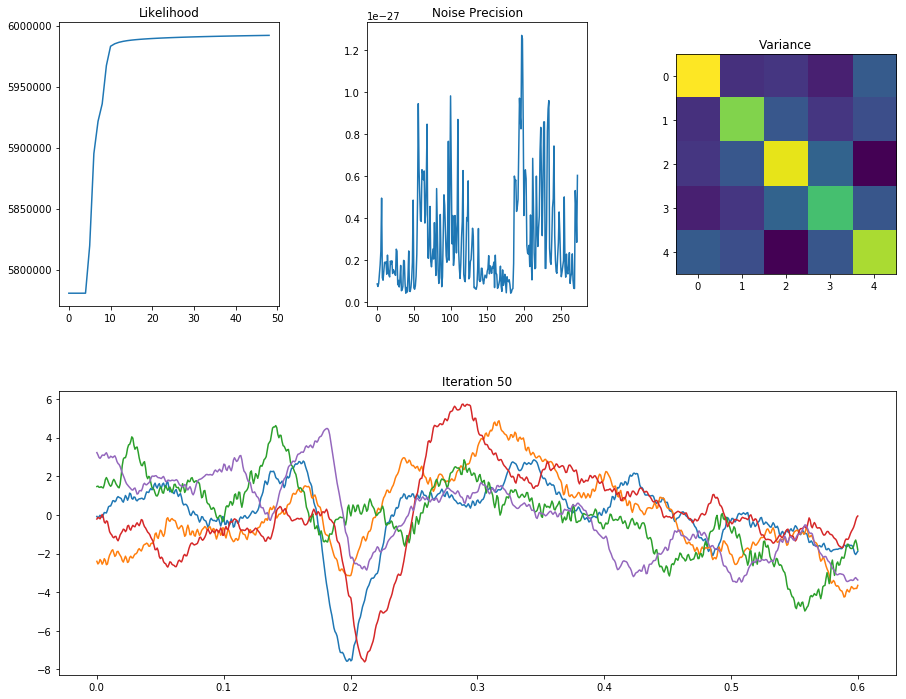

In [14]:
# initialize with random mixing matrix:
num_t = y.shape[1]
ryy = np.matmul(y,y.transpose())/num_t #auto-correlation
scaling = np.sum(np.diag(np.diag(ryy)))
mixing_matrix = np.random.rand(274,5)*scaling #random mixing matrix for initialization

a, npm, xbar, igamma = bfa(y, num_fa = 5, num_it = 50, mixing_matrix = mixing_matrix)